In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import (Activation, Concatenate, Conv2D,
                                     Conv2DTranspose, Input, LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.layers import InstanceNormalization

import tensorflow_datasets as tfds

%matplotlib inline

/Users/billyluqiu/miniforge3/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
generator_g_import = tf.keras.models.load_model('generated_models/generator_g.h5')
generator_f_import = tf.keras.models.load_model('generated_models/generator_f.h5')
discriminator_x_import = tf.keras.models.load_model('generated_models/discriminator_x.h5')
discriminator_y_import = tf.keras.models.load_model('generated_models/discriminator_y.h5')


2022-12-06 15:19:46.317375: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-06 15:19:46.317496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [3]:
# Load dataset
data, metadata = tfds.load('cycle_gan/monet2photo', with_info=True, as_supervised=True)

train_x, train_y, test_x, test_y = data['trainA'], data['trainB'], data['testA'], data['testB']

In [4]:
# Settings
epochs = 50

LAMBDA = 10

img_rows, img_cols, channels = 256, 256, 3
weight_initializer = RandomNormal(stddev=0.02)

gen_g_optimizer = gen_f_optimizer = Adam(lr=0.0002, beta_1=0.5)
dis_x_optimizer = dis_y_optimizer = Adam(lr=0.0002, beta_1=0.5)

/Users/billyluqiu/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
# Normalize images to [-1, 1] and reshape
def preprocess_image(image, _):
    return tf.reshape(tf.cast(tf.image.resize(image, (int(img_rows), int(img_cols))), tf.float32) / 127.5 - 1, (1, img_rows, img_cols, channels))

In [6]:
# Map the normalization onto the dataset
train_x = train_x.map(preprocess_image)
train_y = train_y.map(preprocess_image)
test_x = test_x.map(preprocess_image)
test_y = test_y.map(preprocess_image)

In [7]:
test_x

<MapDataset shapes: (1, 256, 256, 3), types: tf.float32>

In [8]:
def generate_images():
    # Sample images
    print(test_x)
    x = next(iter(test_x.shuffle(1000))).numpy()
    y = next(iter(test_y.shuffle(1000))).numpy()
    print(x)
    # Get predictions for those images
    y_hat = generator_g_import.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f_import.predict(y.reshape((1, img_rows, img_cols, channels)))
    


#BELOW THIS IS THE TEST DATA FROM KAGGLE

In [9]:
images = tf.keras.utils.image_dataset_from_directory(
  "/Users/billyluqiu/Desktop/fall2022/ece588Final/billy/images", batch_size=1)

Found 300 files belonging to 1 classes.


In [10]:
images2 = tf.keras.utils.image_dataset_from_directory(
  "/Users/billyluqiu/Desktop/fall2022/ece588Final/billy/images2", batch_size=1)

Found 7038 files belonging to 1 classes.


In [11]:
test_y = images.map(preprocess_image)

In [12]:
test_x = images2.map(preprocess_image)

In [13]:
test_x

<MapDataset shapes: (1, 256, 256, 3), types: tf.float32>

In [14]:
gen_g_optimizer = gen_f_optimizer = Adam(lr=0.0002, beta_1=0.5)
dis_x_optimizer = dis_y_optimizer = Adam(lr=0.0002, beta_1=0.5)

In [15]:
 # Losses
loss = BinaryCrossentropy(from_logits=True)

# Measures how close to one real images are rated, and how close to zero fake images are rated
def discriminator_loss(real, generated):
    # Multiplied by 0.5 so that it will train at half-speed
    return (loss(tf.ones_like(real), real) + loss(tf.zeros_like(generated), generated)) * 0.5

# Measures how real the discriminator believes the fake image is
def gen_loss(validity):
    return loss(tf.ones_like(validity), validity)

# Measures similarity of two images.  Used for cycle and identity loss
def image_similarity(image1, image2):
    return tf.reduce_mean(tf.abs(image1 - image2))

In [16]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [17]:
mse_generated = []
mse_original = []

In [18]:
generator_f_import.compile(gen_f_optimizer, generator_loss)

In [19]:
loss_arr = []

In [20]:
import matplotlib


In [21]:
i = 1
for x in test_x:
    x_numpy = x.numpy().reshape((1, img_rows, img_cols, channels))
    y_hat = generator_f_import.predict(x_numpy)
    x_hat = generator_g_import.predict(y_hat)
    #loss, acc = generator_f_import.evaluate(x_numpy, y_hat)
    # loss_arr.append(loss)
    # break
    normalizedData = (y_hat[0]-np.min(y_hat[0]))/(np.max(y_hat[0])-np.min(y_hat[0]))
    normalizedDataX = np.array(x[0])
    normalizedDataX = (normalizedDataX-np.min(normalizedDataX))/(np.max(normalizedDataX)-np.min(normalizedDataX))
    matplotlib.image.imsave('test_images/'+ str(i) + '.png', normalizedData)
    matplotlib.image.imsave('test_images_original/'+ str(i) + '.png', normalizedDataX)

    mse_generated.append(np.mean((y_hat[0] - x_hat[0])**2))
    mse_original.append(np.mean((x_numpy[0] - x_hat[0])**2))

    i += 1

    if i % 500 == 0:
        print(i)
    

2022-12-06 15:19:56.834535: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-06 15:19:57.128207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-06 15:19:57.742790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


In [22]:
np.amax(normalizedDataX)

1.0

In [23]:
mse_generated

[0.01283256,
 0.109321214,
 0.003621077,
 0.0027041547,
 0.043688405,
 0.16390741,
 0.18753783,
 0.15491502,
 0.17654347,
 0.0031008201,
 0.15366274,
 0.009982002,
 0.1223327,
 0.1429698,
 0.24584597,
 0.0020541002,
 0.0017358594,
 0.048586965,
 0.17656906,
 0.00428399,
 0.0060271877,
 0.0023475445,
 0.18837173,
 0.060788095,
 0.17368644,
 0.004276885,
 0.19741201,
 0.023442864,
 0.20566566,
 0.017763289,
 0.033172477,
 0.0022246025,
 0.0064963414,
 0.20724855,
 0.0076658386,
 0.17871606,
 0.17902137,
 0.23859274,
 0.20428367,
 0.19159947,
 0.17847393,
 0.005772581,
 0.17361636,
 0.0036597075,
 0.027673436,
 0.0031058856,
 0.01219191,
 0.14339148,
 0.010626872,
 0.007550888,
 0.0061880876,
 0.008282796,
 0.022308268,
 0.0038801946,
 0.16300128,
 0.0058791935,
 0.18777752,
 0.20819902,
 0.0071732886,
 0.056164306,
 0.0034032315,
 0.19497494,
 0.010066391,
 0.068853624,
 0.09203023,
 0.22895402,
 0.0211791,
 0.032407247,
 0.16013233,
 0.16382456,
 0.059911292,
 0.1965871,
 0.050953258,
 

In [24]:
np.mean((x_numpy[0] - x_hat[0])**2)

0.023417443

(array([5.753e+03, 1.225e+03, 5.200e+01, 2.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.00158216, 0.02318895, 0.04479573, 0.06640252, 0.08800931,
        0.10961609, 0.13122287, 0.15282966, 0.17443644, 0.19604322,
        0.21765001], dtype=float32),
 <BarContainer object of 10 artists>)

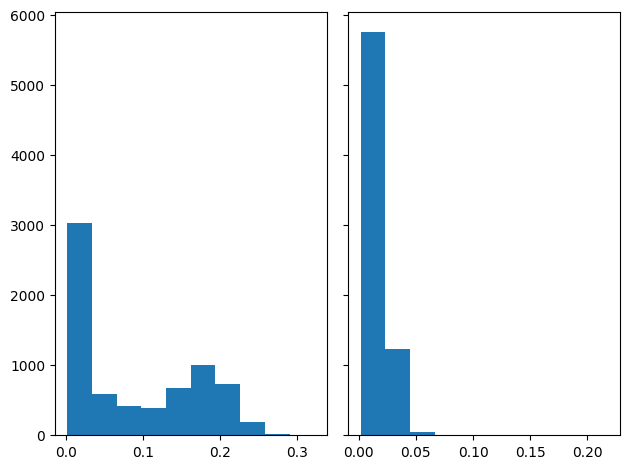

In [25]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(mse_generated)
axs[1].hist(mse_original)